# Simulación Robotic arm witch FetchPickAndPlace from Gymnasium-Robotics using Mujoco y stable baselines3

En este notebook vamos a simular y entrenar un agente(brazo robotico) en el entorno `FetchPickAndPlace-v4` utilizando `gymnasium`, `mujoco` y `stable-baselines3`.

In [ ]:
!pip install tensorboard

Comprobacion de la correcta instalacion de la libreria gymnasium robotics, la cual  es el core de la simulacion 

In [ ]:
import gymnasium_robotics
import importlib.metadata
print(importlib.metadata.version("gymnasium-robotics"))
print(gymnasium_robotics.__file__)

## 1. Simulación básica del entorno FetchPickAndPlace

El entorno FetchPickAndPlace es uno de los más utilizados en simulaciones de robótica en _gymnasium-robotics_ (antes parte de OpenAI Gym). Es un entorno de simulación de un brazo robótico Fetch que usan el motor de física MuJoCo y que tiene como objetivo tomar un objeto y llevarlo a una posicion objetivo. Este entorno nos retorna un diccionario con:

-  El estado del brazo y el objeto(posición, velocidad, etc.)  'observation': [...],
-  La Posición actual del objeto  'achieved_goal': [...],
-  La Posición objetivo del objeto  'desired_goal': [...]
   
Util para aplicar técnicas como Hindsight Experience Replay (HER), de la cual hablaremos mas adelante.

Por defecto se definen recompensas escasas siendo 0 la recompensa obtenida si el objeto se encuentra en cierto umbral de cercania al objetivo y -1 en cualquier otro caso.

Tambien se definio la duracion de cada episodio en 50 pasos. 

In [ ]:
import os
os.environ["MUJOCO_GL"] = "glfw"

import gymnasium as gym
import gymnasium_robotics  # Importar el paquete de robótica
import numpy as np

# Crear entorno con renderizado
env = gym.make("FetchPickAndPlace-v4", render_mode="human")
obs, info = env.reset()

# Simular acciones aleatorias
for _ in range(50):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        obs, info = env.reset()

env.close()

## 2. Entrenamiento con PPO (Stable-Baselines3)

Para nuestro primer acercamiento al entrenamiento del agente, decidimos utilizar el algoritmo Proximal Policy Optimization (PPO) de la biblioteca Stable-Baselines3. PPO es un algoritmo de aprendizaje por refuerzo basado en políticas, ampliamente reconocido por su estabilidad y rendimiento en entornos complejos de control continuo, como FetchPickAndPlace. En este caso el agente se entreno en un entorno donde debe aprender a alcanzar un objeto, agarrarlo y moverlo a una posicion objetivo. Cada paso genera una observación, una recompensa y una señal de si el episodio ha terminado. El modelo PPO aprende a optimizar sus acciones para maximizar la recompensa a lo largo de varios episodios.

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback

# --- Carpeta para guardar modelos ---
save_dir = "./ppo_models/"
os.makedirs(save_dir, exist_ok=True)

# --- Callback para guardar checkpoints cada 15,000 pasos ---
checkpoint_callback = CheckpointCallback(
    save_freq=15_000,
    save_path=save_dir,
    name_prefix="ppo_checkpoint"
)

# Crear entorno vectorizado
vec_env = make_vec_env("FetchPickAndPlace-v4", n_envs=1)

# Crear modelo PPO con MultiInputPolicy
model = PPO("MultiInputPolicy", vec_env, verbose=1, tensorboard_log="./ppo_tensorboard/")

# Entrenar el modelo
model.learn(total_timesteps=50_000, callback=checkpoint_callback)

# Guardar modelo
model.save("./ppo_models/ppo_model_final")
env.close()

Using cpu device
Logging to ./ppo_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -46.5    |
|    success_rate    | 0.05     |
| time/              |          |
|    fps             | 364      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -48.3       |
|    success_rate         | 0.0247      |
| time/                   |             |
|    fps                  | 317         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006895615 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 

### Continuacion entrenamiento con PPO

In [3]:
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback

# --- Callback para guardar checkpoints cada 15,000 pasos ---
checkpoint_callback = CheckpointCallback(
    save_freq=15_000,
    save_path=save_dir,
    name_prefix="ppo_checkpoint"
)

# Crear entorno vectorizado
vec_env = make_vec_env("FetchPickAndPlace-v4", n_envs=1)

# --- Cargar modelo desde un checkpoint específico ---
model = PPO.load("./ppo_models/ppo_model_final", env=env)

# Continuar entrenamiento
model.learn(
    total_timesteps=15_000,       # O los pasos que quieras añadir
    callback=checkpoint_callback,
    reset_num_timesteps=False      # Esto es CRUCIAL para no perder continuidad
)

model.save("./ppo_models/ppo_final_continuado")
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -47.5    |
|    success_rate    | 0.05     |
| time/              |          |
|    fps             | 300      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 53248    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -47         |
|    success_rate         | 0.06        |
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.009157378 |
|    clip_

### 3. Evaluación del agente entrenado

In [4]:
from stable_baselines3 import PPO

# Cargar entorno y modelo entrenado
env = gym.make("FetchPickAndPlace-v4", render_mode="human")
model = PPO.load("./ppo_models/ppo_final_continuado")

obs, info = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs, info = env.reset()

env.close()

# 2 Entrenamiento con SAC (Stable-Baselines3)

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback

# Crear entorno
env = gym.make("FetchPickAndPlace-v4")

# Crear directorio para guardar modelos
save_dir = "./sac_models/"
os.makedirs(save_dir, exist_ok=True)

# Callback para guardar cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_models", # Carpeta donde se guardan
    name_prefix="sac_model"        # Prefijo del archivo
)

# Crear modelo SAC
model = SAC("MultiInputPolicy", env, verbose=1, tensorboard_log="./sac_logs/")

# Entrenar con checkpoints
model.learn(total_timesteps=160_000, callback=checkpoint_callback)

# Guardar modelo final
model.save(os.path.join(save_dir, "sac_final"))

env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 44       |
|    time_elapsed    | 4        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -4.8     |
|    critic_loss     | 0.0546   |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.199   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 40   

### Reanudar entrenamiento desde checkpoint

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
import os

env = gym.make("FetchPickAndPlace-v4", reward_type="sparse")

# Cargar modelo desde un checkpoint
model = SAC.load("./sac_models/sac_final_continuado", env=env)

checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_models", # Carpeta donde se guardan
    name_prefix="sac_model"        # Prefijo del archivo
)

# Continuar entrenamiento
model.learn(
    total_timesteps=15_000,       # O los pasos que quieras añadir
    callback=checkpoint_callback,
    reset_num_timesteps=False      # Esto es CRUCIAL para no perder continuidad
)

model.save("./sac_models/sac_final_continuado")
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4404     |
|    fps             | 30       |
|    time_elapsed    | 6        |
|    total_timesteps | 220200   |
| train/             |          |
|    actor_loss      | -323     |
|    critic_loss     | 363      |
|    ent_coef        | 0.411    |
|    ent_coef_loss   | 2.29     |
|    learning_rate   | 0.0003   |
|    n_updates       | 220099   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4408     |
|    fps             | 31       |
|    time_e

### Evaluar el agente entrenado

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

model = SAC.load("./sac_models/sac_final_continuado", env=env)

env = gym.make("FetchPickAndPlace-v4", render_mode="human")

n_episodes = 200
successes = []
rewards = []

for ep in range(n_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    success = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        success = info.get("is_success", 0)

    successes.append(success)
    rewards.append(total_reward)

print(f"Success rate: {np.mean(successes):.2f}")
print(f"Recompensa promedio: {np.mean(rewards):.2f}")

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Success rate: 0.00
✅ Recompensa promedio: -50.00


# 3 Entrenamiento con SAC + Her o DDPG + Her

In [5]:
import gymnasium as gym
from stable_baselines3.common.env_util import make_vec_env

# Crear entorno vectorizado
make_vec_env("FetchPickAndPlace-v4", n_envs=1)
 

## Entrenamiento SAC + HER

In [6]:
from stable_baselines3 import SAC
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback

# Crear directorio para guardar modelos
save_dir = "./sac_her_models/"
os.makedirs(save_dir, exist_ok=True)

# Callback para guardar cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_her_models", # Carpeta donde se guardan
    name_prefix="sac_her_model"        # Prefijo del archivo
)

sac_model = SAC(
    policy="MultiInputPolicy",
    env=env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",
    ),
    verbose=1,
    tensorboard_log="./sac_her_tensorboard/",
)

# Entrenar el modelo
sac_model.learn(total_timesteps=15_000, callback=checkpoint_callback)

# Guardar modelo
model.save(os.path.join(save_dir, "sac_her_final"))

#Guardar el buffer
sac_model.save(os.path.join(save_dir, "sac_her_final"))
sac_model.save_replay_buffer(os.path.join(save_dir, "sac_her_buffer"))

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_her_tensorboard/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 76       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.68    |
|    critic_loss     | 0.255    |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps         

### Continuar entrenamiento SAC + HER

In [11]:
from stable_baselines3 import SAC
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
import os

save_dir = "./sac_her_models/"

env = gym.make("FetchPickAndPlace-v4", reward_type="sparse")

# Cargar modelo desde un checkpoint
model = SAC.load("./sac_her_models/sac_her_model_135000_steps", env=env)

# Cargar el buffer de experiencia
model.load_replay_buffer("./sac_her_models/sac_her_buffer")

print("Pasos registrados:", model.num_timesteps)

checkpoint_callback = CheckpointCallback(
    save_freq=15000,                # Cada 15,000 pasos
    save_path="./sac_her_models",   # Carpeta donde se guardan
    name_prefix="sac_her_model"        # Prefijo del archivo
)

# Continuar entrenamiento
model.learn(
    total_timesteps=15_000,       # O los pasos que quieras añadir
    callback=checkpoint_callback,
    reset_num_timesteps=False      
)

model.save(os.path.join(save_dir, "sac_her_final_continuado"))
model.save_replay_buffer(os.path.join(save_dir, "sac_her_buffer_continuado"))

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 135000
Logging to ./sac_her_tensorboard/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -46.5    |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 2700     |
|    fps             | 41       |
|    time_elapsed    | 1        |
|    total_timesteps | 135050   |
| train/             |          |
|    actor_loss      | -30.4    |
|    critic_loss     | 3.91     |
|    ent_coef        | 0.0546   |
|    ent_coef_loss   | -6.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 134948   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -46.5    |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 2704     |
|    fps

KeyboardInterrupt: 

### Evaluar Entrenamiento del Modelo SAC + HER

In [8]:
import os
import json
import gymnasium as gym
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Configuración ---
model_path = "./sac_her_models/sac_her_final_continuado"  # Ajusta si tu modelo está en otra carpeta
env_id = "FetchPickAndPlace-v4"  # Asegúrate de usar la misma versión que en el entrenamiento

save_dir_E = "./sac_her_evaluation/"
output_file = "./sac_her_eval_results.json"
os.makedirs(save_dir_E, exist_ok=True)

# --- Crear entorno con renderización ---
env = gym.make(env_id, render_mode="human")
env = Monitor(env)
env = DummyVecEnv([lambda: env])  # Necesario para SAC y compatibilidad con stable_baselines3

# --- Cargar modelo entrenado ---
model = SAC.load(model_path, env=env)

# --- Evaluación ---
n_episodes = 100
rewards = []
successes = []
results = []

print("\n[Evaluación del modelo SAC + HER]\n")
print("Pasos registrados:", model.num_timesteps)

for ep in range(n_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    success = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        env.render()
        total_reward += reward[0]  # dummy vector env
        success = info[0].get("is_success", 0)

    results.append({
        "episode": int(ep + 1),
        "reward": float(total_reward),
        "success": int(success)
    })

# --- Guardar resultados en JSON ---
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

# --- Estadísticas finales ---
success_rate = np.mean([r["success"] for r in results])
avg_reward = np.mean([r["reward"] for r in results])

print("\n Evaluación completada")
print(f" Tasa de éxito promedio: {success_rate:.2f}")
print(f" Recompensa promedio: {avg_reward:.2f}")
print(f" Resultados guardados en: {output_file}")

env.close()


[Evaluación del modelo SAC + HER]

Pasos registrados: 16000

 Evaluación completada
 Tasa de éxito promedio: 0.03
 Recompensa promedio: -48.50
 Resultados guardados en: ./sac_her_eval_results.json


# Entrenamiento DDPG + HER

In [4]:
import os
from stable_baselines3 import DDPG
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrapping env
env = DummyVecEnv([lambda: Monitor(env)])

# Crear carpeta para modelos
save_dir = "./ddpg_her_models"
os.makedirs(save_dir, exist_ok=True)

# Callback de checkpoints cada 15k steps
checkpoint_callback = CheckpointCallback(
    save_freq=15000,
    save_path=save_dir,
    name_prefix="ddpg_her_model"
)

# Inicializar modelo DDPG + HER
ddpg_model = DDPG(
    policy="MultiInputPolicy",
    env=env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future",
    ),
    verbose=1,
    tensorboard_log="./her_ddpg_tensorboard/"
)

# Entrenar por primera vez
ddpg_model.learn(total_timesteps=30000, callback=checkpoint_callback)

# Guardar modelo y buffer
ddpg_model.save(os.path.join(save_dir, "ddpg_her_final"))
ddpg_model.save_replay_buffer(os.path.join(save_dir, "ddpg_her_buffer"))

Using cpu device


d:\Universidad\6 semestre\Sistems Sciences Foundations\Final Proyect 2\Ve_ArmSimulation2\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Logging to ./her_ddpg_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -37.5    |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 67       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.23     |
|    critic_loss     | 0.018    |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -43.8    |
|    success_rate    | 0.125    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 7        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 0.21     |
|    cr

### Continuar Entrenamiento DDPG + HER

In [5]:
from stable_baselines3.common.utils import set_random_seed

save_dir = "./ddpg_her_models"

# Especifica la versión del checkpoint
model_path = os.path.join(save_dir, f"ddpg_her_final")
replay_buffer_path = os.path.join(save_dir, "ddpg_her_buffer")

# Cargar modelo y buffer
model = DDPG.load(model_path, env=env)
model.load_replay_buffer(replay_buffer_path)

# Continuar entrenamiento
print("\n[Continuando entrenamiento desde checkpoint]")
model.learn(
    total_timesteps=15000,
    callback=checkpoint_callback,
    reset_num_timesteps=False
)

# Guardar versión final
model.save(os.path.join(save_dir, "ddpg_her_final_continuado"))
model.save_replay_buffer(os.path.join(save_dir, "ddpg_her_replay_buffer_final"))


[Continuando entrenamiento desde checkpoint]
Logging to ./her_ddpg_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -47      |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 604      |
|    fps             | 38       |
|    time_elapsed    | 5        |
|    total_timesteps | 30200    |
| train/             |          |
|    actor_loss      | -2.23    |
|    critic_loss     | 0.318    |
|    learning_rate   | 0.001    |
|    n_updates       | 30099    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -47      |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 608      |
|    fps             | 39       |
|    time_elapsed    | 10       |
|    total_timesteps | 30400    |
| train/             |       

### Evaluacion del modelo DDPG + HER

In [11]:
import os
import time
import json
import gymnasium as gym
import numpy as np

# Crear carpeta para guardar resultados
eval_dir = "ddpg_her_evaluation"
os.makedirs(eval_dir, exist_ok=True)
output_file = os.path.join(eval_dir, "visualization_results.json")

print("\n[Evaluación visual del entorno DDPG + HER]")

# Crear una nueva instancia del entorno 
render_env = gym.make("FetchPickAndPlace-v4", render_mode="human")  

# Lista para guardar resultados por episodio
results = []

episodes_ddpg = 100 #Número de episodios a evaluar

# Reset del entorno y ejecución de episodios
for episode in range(episodes_ddpg):
    obs, _ = render_env.reset()
    done = False
    episode_data = {
        "episode": episode + 1,
        "success": False,
        "total_reward": 0.0
    }

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = render_env.step(action)
        done = terminated or truncated
        total_reward += float(reward)
        success = bool(info.get("is_success", False))

        time.sleep(0.05)

    results.append({
        "episode": episode + 1,
        "success": success,
        "total_reward": float(total_reward)  
    })

# Guardar resultados en JSON
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

# Calcular métricas
successes = [ep["success"] for ep in results]
rewards = [ep["total_reward"] for ep in results]

# Mostrar métricas en consola
success_rate = float(np.mean([r["success"] for r in results]))
avg_reward = float(np.mean([r["total_reward"] for r in results]))

print(f"\n Resultados de evaluación DDPG + HER:")
print(f" Tasa de éxito promedio: {success_rate:.2f}")
print(f" Recompensa promedio: {avg_reward:.2f}")
print(f" Resultados guardados en: {output_file}")

# Cerrar entorno
render_env.close()


[Evaluación visual del entorno DDPG + HER]


d:\Universidad\6 semestre\Sistems Sciences Foundations\Final Proyect 2\Ve_ArmSimulation2\lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



📊 Resultados de evaluación DDPG + HER:
✅ Tasa de éxito promedio: 0.03
🎯 Recompensa promedio: -2491.62
📁 Resultados guardados en: ddpg_her_evaluation\visualization_results.json


# Comparacion algoritmos de aprendizaje

Evaluando modelo: SAC
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 220000
Evaluando modelo: SAC + HER
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 60000
Evaluando modelo: DDPG + HER
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 45000
Evaluando modelo: PPO
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Pasos registrados: 51200

[Comparación de rendimiento]
       Modelo  Recompensa Media  Tasa de Éxito
0         SAC        -49.154999          0.011
1   SAC + HER        -47.964001          0.040
2  DDPG + HER        -47.872002          0.042
3         PPO        -47.891998          0.042


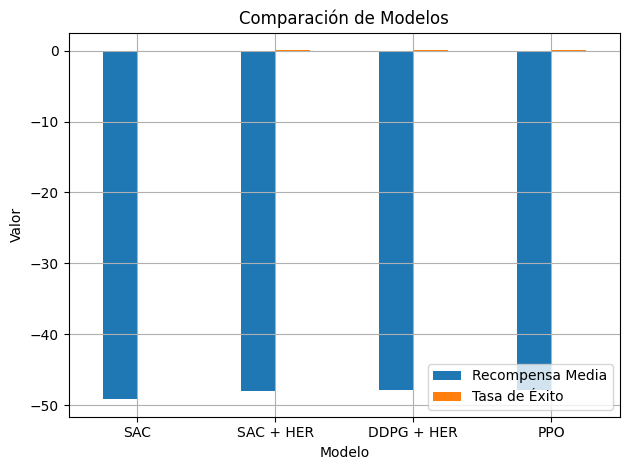

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import SAC, DDPG, PPO

save_dir_sac = "./sac_models/"

# Diccionario con los modelos a comparar
models_info = {
    "SAC": ("./sac_models/sac_final_continuado", SAC),
    "SAC + HER": ("./sac_her_models/sac_her_final_continuado", SAC),
    "DDPG + HER": ("./ddpg_her_models/ddpg_her_final_continuado", DDPG),
    "PPO": ("./fetch_pick_and_place_ppo", PPO),
}

# Evaluación
def evaluate_model(name, path, model_class, episodes=1000):
    print(f"Evaluando modelo: {name}")

    test_env = gym.make("FetchPickAndPlace-v4", render_mode=None)
    model = model_class.load(path, env=test_env)
    print("Pasos registrados:", model.num_timesteps)

    rewards = []
    success = []

    for _ in range(episodes):
        obs, _ = test_env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
        success.append(info.get("is_success", 0.0))

    return {
        "Modelo": name,
        "Recompensa Media": np.mean(rewards),
        "Tasa de Éxito": np.mean(success)
    }

# Evaluar todos los modelos
results = [evaluate_model(name, path, cls) for name, (path, cls) in models_info.items()]
df = pd.DataFrame(results)

# Mostrar tabla de comparación
print("\n[Comparación de rendimiento]")
print(df)

# Visualizar
df.plot(x="Modelo", y=["Recompensa Media", "Tasa de Éxito"], kind="bar", rot=0)
plt.title("Comparación de Modelos")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()
